# Model Training

## Table of Contents
- Evaluation Metrics Used
- Modelling
- Comparison of Models
- Results

<br>


## Evaluation Metrics Used

#### Accuracy
Accuracy provides a ratio of correctly predicted observations to the total observations. 
**Formula**:
$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$

#### Confusion Matrix and Related Terms
The confusion matrix is a table layout that allows visualization of the performance of the algorithm, where each number in the matrix represents:
- **TP (True Positives)**: Correctly predicted positive observations.
- **TN (True Negatives)**: Correctly predicted negative observations.
- **FP (False Positives)**: Incorrectly predicted as positive.
- **FN (False Negatives)**: Incorrectly predicted as negative.

#### Precision, Recall, and F1-Score
- **Precision**:
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
Precision measures the accuracy of positive predictions.

- **Recall** (or Sensitivity or TPR):
$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
Recall measures the ability of a model to find all the relevant cases (all positive samples).

- **F1-Score**:
$$ \text{F1-Score} = 2 \times \left( \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \right) $$
The F1-Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. A high F1-score shows a model can classify the positive class correctly, while not misclassifying many negative classes as positive.

<br>

## Import data and train_test_split

In [27]:
import pandas as pd
df = pd.read_csv("data/cleaned_df_v2.csv", index_col=False)
df = df.iloc[: , 1:]

# convert date
df['year_month'] = pd.to_datetime(df['year_month'])
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

In [28]:
from sklearn.model_selection import train_test_split

features = ['year', 'month', 'us_state', 'make', 'phone_series',  'model_family','model_age_months', 
            'predecessor', 'successor', 'model', 'sku', 'sku_no_colour', 'colour', 'size', 'claims', 
            'ir_rate_swap', 'ir_rate_replacement', 'ir_rate_monthly', 'churn_rate'] # 19 features
target = 'closing_subs_monthly'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

X_train.head()

,year,month,us_state,make,phone_series,model_family,model_age_months,predecessor,successor,model,sku,sku_no_colour,colour,size,claims,ir_rate_swap,ir_rate_replacement,ir_rate_monthly,churn_rate
6615,2023,6,Nevada,Apple,IPHONE 12,APPLE IPHONE 12 PRO MAX,31,APPLE IPHONE 11 PRO MAX,APPLE IPHONE 13 PRO MAX,IPHONE 12 PRO MAX 5G 256GB GRAPHITE,IPH12PRM5G256GRY,IPH12PRM5G256,Gray,256,3.0,0.0,0.0,0.001585,0.049128
9440,2023,5,Nevada,Apple,IPHONE XR,APPLE IPHONE XR,55,APPLE IPHONE X,APPLE IPHONE 11,IPHONE XR 64GB BLACK,IPHXR64BLK,IPHXR64,Black,64,0.0,0.0,0.0,0.000000,0.055838
1549,2022,12,Texas,Oppo,OPPO A90,OPPO A94,21,First Model,Last Model,A94 128GB SILVER,A94128SIL,A94128,Silver,128,0.0,0.0,0.0,0.000000,0.073171
10717,2019,9,Nevada,Samsung,SAMSUNG GALAXY NOTE 9,SAMSUNG GALAXY NOTE 9,13,First Model,Last Model,GALAXY NOTE 9 128GB BLACK,NOTE9128BLK,NOTE9128,Black,128,16.0,0.0,0.0,0.002614,0.035778
3034,2021,4,California,Samsung,GALAXY S21,SAMSUNG GALAXY S21 PLUS,14,SAMSUNG GALAXY S20 PLUS,SAMSUNG GALAXY S22 PLUS,GALAXY S21 PLUS 5G 256GB BLACK,GXYS21P5G256BLK,GXYS21P5G256,Black,256,0.0,0.0,0.0,0.000000,0.027237


In [29]:
categorical_cols = ["us_state", "make", "phone_series", "model_family", "colour", "size"]

## RandomForestRegressor to predict closing_subs_monthly

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42)) 
])

# Model training
model_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1870.7079620144557


RMSE of 1870.71 indicates that, on average, the model's predictions are off by about 1870.71 units.



## Time series model: ARIMA (AutoRegressive Integrated Moving Average) model

In [31]:
# Sort by 'year' and 'month'
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group data by month (sum or average claims)
monthly_data = df.groupby('date')['claims'].sum()

# Check the data
print(monthly_data.head())


date
2019-01-01     633.112710
2019-02-01     525.608554
2019-03-01     961.884443
2019-04-01    1101.394905
2019-05-01     948.019294
Name: claims, dtype: float64


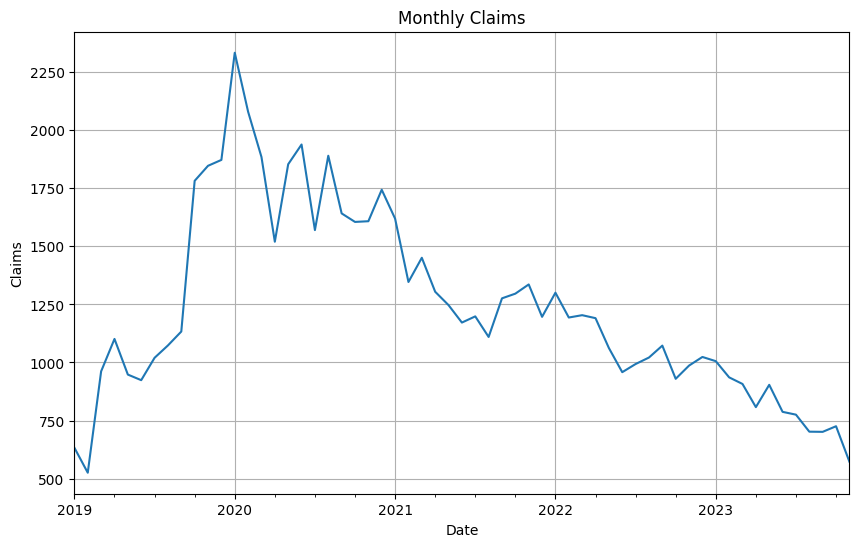

In [32]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
monthly_data.plot()
plt.title('Monthly Claims')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.grid(True)
plt.show()


In [34]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary


ADF Statistic: -1.0084416352340653
p-value: 0.750172970005367


In [35]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
result_diff = adfuller(monthly_data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -6.751875917279571
p-value (Differenced): 2.937052635838381e-09


Now that the data is stationary (or made stationary), you can fit an ARIMA model.

To identify the best parameters (p, d, q) for the ARIMA model, you can use grid search or ACF/PACF plots. However, for simplicity, you can start with some initial parameters.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(monthly_data, order=(5, 1, 0))  # p=5, d=1, q=0 (you may need to tune this)
model_fit = model.fit()

# Summarize the model
print(model_fit.summary())


In [ ]:
# Forecast for the next 12 months (for example)
forecast = model_fit.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data, label='Historical Data')
plt.plot(pd.date_range(monthly_data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('Phone Device Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming `test_data` is the actual data for the forecast period
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
